# Project 5 : Predict markets stocks of Google, Facebook & Amazon.

## MAP670G - Data Stream (2021-2022)
<blockquote> 
Alexandre PERBET<br>
Cyril NERIN<br>
Hugo RIALAN<br>
</blockquote>

__PART 1: DATA PROCESSING AND BATCH MACHINE LEARNING__

<br>
<img src="Google_Facebook_Amazon.PNG" width="600" height="600">
<br>

__Project 5 : Collect trading data using Yahoo finance API and use online regression to predict markets stocks of Google, Facebook & Amazon.__

__Option 2 :__ For each of these 5 countries, use 1 major industry stock data
For ex, in US Google,  in France BNP Paribas, in China Alibaba, in Russia or England, use a major international industry.
This option was initially given in the project.

For each option, each group should use at least 3 different data streams, with online and adaptive regression on RIVER (such as https://riverml.xyz/latest/api/tree/HoeffdingAdaptiveTreeRegressor/) and compare the performances with batch regression model (scikit-learn).

__ToDo:__ Compare online Regression vs Batch Regression and discuss the performance.

__Bonus :__ Use recent stock market data (from January to March 2022).

__Online resources:__ 
You can use the Python library to collect Yahoo Finance data in streaming https://pypi.org/project/yfinance/
You can compute time-series statistics and moving averages (MACD) for features engineering https://www.statsmodels.org/stable/tsa.html


In [104]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Libraries

In [105]:
!pip3 install --quiet -r requirements.txt

In [106]:
import sys 
print("Python version: {}". format(sys.version))

import IPython
from IPython import display
from IPython.display import Markdown, display
print("IPython version: {}". format(IPython.__version__))

import numpy as np
print("NumPy version: {}". format(np.__version__))

import scipy as sp
from scipy import stats
print("SciPy version: {}". format(sp.__version__))

import pandas as pd
print("pandas version: {}". format(pd.__version__))

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

import seaborn as sns
print("seaborn version : {}". format(sns.__version__))
sns.set()

import kafka
from kafka.admin import KafkaAdminClient, NewTopic
from kafka import KafkaProducer
from kafka import KafkaConsumer
print("kafka version : {}". format(kafka.__version__))

import yfinance as yf
print("yfinance version : {}". format(yf.__version__))

import statsmodels
print("statsmodels version : {}". format(statsmodels.__version__))
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss

import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
print("scikit-learn version : {}". format(sklearn.__version__))

import river
from river import base
from river import drift
from river import datasets
from river import anomaly
from river.anomaly.hst import HalfSpaceTrees, make_padded_tree
from river import compose
from river import metrics
from river import preprocessing

print("river version : {}". format(river.__version__))

import ipywidgets as widgets
print("ipywidgets version : {}". format(widgets.__version__))

import time
from time import perf_counter
from datetime import datetime, date, timedelta

from enum import Enum, auto

import math

import pprint

import json

import urllib.request

import warnings
warnings.filterwarnings('ignore')

print("====================================")

Python version: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
IPython version: 7.27.0
NumPy version: 1.20.3
SciPy version: 1.7.1
pandas version: 1.3.2
matplotlib version: 3.4.2
seaborn version : 0.11.2
kafka version : 2.0.2
yfinance version : 0.1.70
statsmodels version : 0.13.2
scikit-learn version : 1.0.1
river version : 0.9.0
ipywidgets version : 7.6.5


## Utility functions

In [107]:
def printmd(text, couleur=None):
    """
    Printing of the string text by choosing the style (for example bold) and the color (couleur)
    """
    colorstr = "<span style='color:{}'>{}</span>".format(couleur, text)
    display(Markdown(colorstr))

## Launching the servers
<p><b>LAUNCHING ZOOKEEPER AND KAFKA SERVER ON WINDOWS</b></p>
<p> In a <b>first terminal</b>, run the following commands:
<p>cd %KAFKA_DIR%
<p>.\bin\windows\zookeeper-server-start.bat .\config\zookeeper.properties
<p>  </p>
<p> In a <b>second terminal</b>, run the following commands:
<p>cd %KAFKA_DIR%
<p>.\bin\windows\kafka-server-start.bat .\config\server.properties
<p>  -- </p>
<p>we assume that Zookeeper is running default on localhost:2181 and Kafka on localhost:9092.</p>

# Selection of data to be used (historical or recent data)

__HISTORICAL : Daily stock market data for the last 20 years__

__RECENT : Hourly stock market data from January 2021 to March 2022__

In [108]:
class Information(Enum):
    HISTORICAL = auto()
    RECENT = auto()

the_data_type = Information.RECENT

if the_data_type == Information.RECENT:
    print("Analysis of hourly stock market data from January 2021 to March 2022")
elif the_data_type == Information.HISTORICAL:
    print("Analysis of daily stock market data for the last 20 years")
else:
    print("ERROR : 'the_data_type' is not correctly set")
    print("============================================")

Analysis of hourly stock market data from January 2021 to March 2022


# Get stock market data from Google, Facebook, Amazon, Total, Gazprom, Alibaba, BNP-Paribas, BP and Ferrari

## stock market data identifiers

In [109]:
the_GAF = ["google", "amazon", "facebook"]
All_the_companies = ["google",
                     "facebook",
                     "amazon",
                     "total",
                     "gazprom",
                     "alibaba",
                     "bnp_paribas",
                     "BP",
                     "ferrari"]

tick = {}
tick["google"] = "GOOG"
tick["facebook"] = "FB"
tick["amazon"] = "AMZN"
tick["total"] = "TTE"
tick["gazprom"] = "OGZPY"
tick["alibaba"] = "BABA"
tick["bnp_paribas"] = "BNPQY"
tick["BP"] = "BP"
tick["ferrari"] = "RACE"

the_GAF_tickers = " ".join(map(str, [v for k, v in tick.items() if k in the_GAF]))
all_the_tickers = " ".join(map(str, [v for v in tick.values()]))
GAF_tick = yf.Tickers(the_GAF_tickers)
ALL_tick = yf.Tickers(all_the_tickers)

google = GAF_tick.tickers[tick["google"]]
facebook = GAF_tick.tickers[tick["facebook"]]
amazon = GAF_tick.tickers[tick["amazon"]]

total = yf.Ticker(tick["total"])
gazprom = yf.Ticker(tick["gazprom"])
alibaba = yf.Ticker(tick["alibaba"])
bnp_paribas = yf.Ticker(tick["bnp_paribas"])
BP = yf.Ticker(tick["BP"])
ferrari = yf.Ticker(tick["ferrari"])

## Get information on companies

In [110]:
google_info = google.info
facebook_info = facebook.info
amazon_info = amazon.info
total_info = total.info
gazprom_info = gazprom.info
alibaba_info = alibaba.info
bnp_paribas_info = bnp_paribas.info
BP_info = BP.info
ferrari_info = ferrari.info

stock_info = [google_info, facebook_info, amazon_info,
              total_info, gazprom_info, alibaba_info,
              bnp_paribas_info, BP_info, ferrari_info]

for i, info in enumerate(stock_info):
    print("---------- {} ----------".format(All_the_companies[i]))
    print("{} - sector: {}; country: {}; logo: {}" \
        .format(info["shortName"],
                info["sector"],
                info["country"],
                info["logo_url"]))
    print("")

---------- google ----------
Alphabet Inc. - sector: Communication Services; country: United States; logo: https://logo.clearbit.com/abc.xyz

---------- facebook ----------
Meta Platforms, Inc. - sector: Communication Services; country: United States; logo: https://logo.clearbit.com/investor.fb.com

---------- amazon ----------
Amazon.com, Inc. - sector: Consumer Cyclical; country: United States; logo: https://logo.clearbit.com/amazon.com

---------- total ----------
TotalEnergies SE - sector: Energy; country: France; logo: https://logo.clearbit.com/totalenergies.com

---------- gazprom ----------
GAZPROM PUBLIC JOINT STOCK COMP - sector: Energy; country: Russia; logo: https://logo.clearbit.com/gazprom.com

---------- alibaba ----------
Alibaba Group Holding Limited - sector: Consumer Cyclical; country: China; logo: https://logo.clearbit.com/alibabagroup.com

---------- bnp_paribas ----------
BNP PARIBAS ADR EACH REPR 1/2 O - sector: Financial Services; country: France; logo: https://l

## Set parameters for yfinance package

In [111]:
if the_data_type == Information.RECENT:
    deb = "2021-01-01"
    fin = "2022-03-31"
    interval = "1h"
    init_type = True
elif the_data_type == Information.HISTORICAL:
    deb = "2002-01-01"
    fin = "2022-03-31"
    interval = "1d"
    init_type = True
else:
    init_type = False
    print("ERROR : 'the_data_type' is not correctly set")
    print("============================================")

## Get stock market data

In [112]:
if init_type:
    print("Get stock market data (interval={}) from {} to {}.".format(interval, deb, fin))
    temps = perf_counter()
    data = yf.download(all_the_tickers, start=deb, end=fin, interval=interval, group_by='ticker')
    temps_recuperation_donnees = perf_counter() - temps
    print("CPU time = {:.3f} seconds".format(temps_recuperation_donnees))
else:
    print("ERROR : 'the_data_type' is not correctly set")
    print("============================================")

Get stock market data (interval=1h) from 2021-01-01 to 2022-03-31.
[*********************100%***********************]  9 of 9 completed
CPU time = 2.215 seconds


## Describe the stock market data collected

In [113]:
data

OGZPY                                        \
                           Open  High   Low  Close Adj Close   Volume   
2021-01-04 09:30:00-05:00  5.81  5.83  5.80  5.820     5.820      0.0   
2021-01-04 10:30:00-05:00  5.81  5.81  5.73  5.730     5.730  36879.0   
2021-01-04 11:30:00-05:00  5.72  5.74  5.69  5.690     5.690  43446.0   
2021-01-04 12:30:00-05:00  5.67  5.72  5.66  5.720     5.720  42528.0   
2021-01-04 13:30:00-05:00  5.72  5.72  5.69  5.712     5.712  45453.0   
...                         ...   ...   ...    ...       ...      ...   
2022-03-25 11:30:00-04:00   NaN   NaN   NaN    NaN       NaN      NaN   
2022-03-25 12:30:00-04:00   NaN   NaN   NaN    NaN       NaN      NaN   
2022-03-25 13:30:00-04:00   NaN   NaN   NaN    NaN       NaN      NaN   
2022-03-25 14:30:00-04:00   NaN   NaN   NaN    NaN       NaN      NaN   
2022-03-25 15:30:00-04:00   NaN   NaN   NaN    NaN       NaN      NaN   

                                 RACE                                      \
                                 Open        High         Low       Close   
2021-01-04 09:30:00-05:00  231.889999  232.309998  230.470001  230.729996   
2021-01-04 10:30:00-05:00  230.589996  231.041397  228.850006  230.850006   
2021-01-04 11:30:00-05:00  230.800003  230.800003  227.220001  228.107697   
2021-01-04 12:30:00-05:00  227.910004  228.970001  227.119995  228.949997   
2021-01-04 13:30:00-05:00  228.720001  229.020004  226.710007  226.955002   
...                               ...         ...         ...         ...   
2022-03-25 11:30:00-04:00  211.669998  212.039993  211.149994  211.500000   
2022-03-25 12:30:00-04:00  211.419998  211.755005  210.729996  211.755005   
2022-03-25 13:30:00-04:00  212.080002  212.639999  211.404404  212.639999   
2022-03-25 14:30:00-04:00  212.529999  212.729996  211.210007  211.809998   
2022-03-25 15:30:00-04:00  211.774994  213.350006  211.600006  213.169998   

                           ...         GOOG                            \
                           ...          Low        Close    Adj Close   
2021-01-04 09:30:00-05:00  ...  1740.949951  1748.239990  1748.239990   
2021-01-04 10:30:00-05:00  ...  1725.000000  1730.589966  1730.589966   
2021-01-04 11:30:00-05:00  ...  1710.880005  1716.534424  1716.534424   
2021-01-04 12:30:00-05:00  ...  1707.849976  1722.277466  1722.277466   
2021-01-04 13:30:00-05:00  ...  1720.229980  1724.395020  1724.395020   
...                        ...          ...          ...          ...   
2022-03-25 11:30:00-04:00  ...  2795.306885  2810.010498  2810.010498   
2022-03-25 12:30:00-04:00  ...  2803.827393  2812.514893  2812.514893   
2022-03-25 13:30:00-04:00  ...  2812.810059  2827.635010  2827.635010   
2022-03-25 14:30:00-04:00  ...  2812.050049  2812.379883  2812.379883   
2022-03-25 15:30:00-04:00  ...  2809.280029  2831.429932  2831.429932   

                                            BP                        \
                             Volume       Open       High        Low   
2021-01-04 09:30:00-05:00  241052.0  21.013399  21.127001  20.760000   
2021-01-04 10:30:00-05:00  165475.0  20.775000  20.775000  20.549999   
2021-01-04 11:30:00-05:00  229129.0  20.700001  20.770000  20.600000   
2021-01-04 12:30:00-05:00  234225.0  20.760000  20.959999  20.700001   
2021-01-04 13:30:00-05:00  144923.0  20.930000  20.959999  20.820000   
...                             ...        ...        ...        ...   
2022-03-25 11:30:00-04:00   97382.0  31.155001  31.235001  30.940001   
2022-03-25 12:30:00-04:00   75237.0  30.969999  31.069901  30.872900   
2022-03-25 13:30:00-04:00   68684.0  30.889999  31.135000  30.889999   
2022-03-25 14:30:00-04:00   96781.0  31.139999  31.170000  31.030001   
2022-03-25 15:30:00-04:00  124051.0  31.055000  31.100000  31.020000   

                                                            
                               Close  Adj Close     Volume  
2021-01-04 09:30:00-05:00  20.780001  20.780001  4089186.0  
2021

In [114]:
data.describe()

OGZPY                                                      \
              Open         High          Low        Close    Adj Close   
count  1986.000000  1986.000000  1986.000000  1986.000000  1986.000000   
mean      7.661972     7.686273     7.638432     7.662503     7.662503   
std       1.547198     1.541677     1.550889     1.547589     1.547589   
min       1.720000     1.750000     1.100000     1.100000     1.100000   
25%       6.136250     6.150000     6.120000     6.140000     6.140000   
50%       7.670000     7.692500     7.652000     7.665000     7.665000   
75%       8.993750     9.019625     8.960000     8.990000     8.990000   
max      10.710000    10.720000    10.690000    10.720000    10.720000   

                            RACE                                         ...  \
             Volume         Open         High          Low        Close  ...   
count  1.986000e+03  2100.000000  2100.000000  2100.000000  2100.000000  ...   
mean   7.809213e+04   219.042949   219.680255   218.389494   219.035805  ...   
std    2.390192e+05    20.342270    20.384299    20.273493    20.312401  ...   
min    0.000000e+00   180.059998   181.940002   178.869995   180.289993  ...   
25%    1.209325e+04   206.218754   206.850006   205.632500   206.307499  ...   
50%    3.025750e+04   213.117500   213.639999   212.570000   213.135002  ...   
75%    6.597650e+04   223.573757   224.100006   223.064995   223.596252  ...   
max    5.216545e+06   278.489990   278.779999   276.779999   278.250000  ...   

              GOOG                                                   BP  \
               Low        Close    Adj Close        Volume         Open   
count  2100.000000  2100.000000  2100.000000  2.100000e+03  2100.000000   
mean   2533.178207  2541.987975  2541.987975  1.600834e+05    26.537306   
std     345.572074   345.938551   345.938551  1.204642e+05     2.485659   
min    1700.000000  1716.534424  1716.534424  0.000000e+00    20.538200   
25%    2282.799988  2292.232544  2292.232544  9.113925e+04    24.803149   
50%    2629.675049  2641.114258  2641.114258  1.303165e+05    26.357450   
75%    2822.707581  2830.586304  2830.586304  1.928030e+05    27.816250   
max    3016.280029  3027.239990  3027.239990  2.005783e+06    34.040001   

                                                                         
              High          Low        Close    Adj Close        Volume  
count  2100.000000  2100.000000  2100.000000  2100.000000  2.100000e+03  
mean     26.629790    26.436163    26.534320    26.534320  1.920882e+06  
std       2.490138     2.476294     2.480073     2.480073  1.497615e+06  
min      20.770000    20.424999    20.540001    20.540001  0.000000e+00  
25%      24.889999    24.719999    24.790001    24.790001  1.005126e+06  
50%      26.440001    26.270500    26.355000    26.355000  1.473993e+06  
75%      27.902500    27.719999    27.811250    27.811250  2.314288e+06  
max      34.160000    34.005001    34.035000    34.035000  1.823072e+07  

[8 rows x 54 columns]

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2105 entries, 2021-01-04 09:30:00-05:00 to 2022-03-25 15:30:00-04:00
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (OGZPY, Open)       1986 non-null   float64
 1   (OGZPY, High)       1986 non-null   float64
 2   (OGZPY, Low)        1986 non-null   float64
 3   (OGZPY, Close)      1986 non-null   float64
 4   (OGZPY, Adj Close)  1986 non-null   float64
 5   (OGZPY, Volume)     1986 non-null   float64
 6   (RACE, Open)        2100 non-null   float64
 7   (RACE, High)        2100 non-null   float64
 8   (RACE, Low)         2100 non-null   float64
 9   (RACE, Close)       2100 non-null   float64
 10  (RACE, Adj Close)   2100 non-null   float64
 11  (RACE, Volume)      2100 non-null   float64
 12  (BNPQY, Open)       2097 non-null   float64
 13  (BNPQY, High)       2097 non-null   float64
 14  (BNPQY, Low)        2097 non-null   float64
 15  (BNPQY,

In [116]:
data.columns

MultiIndex([('OGZPY',      'Open'),
            ('OGZPY',      'High'),
            ('OGZPY',       'Low'),
            ('OGZPY',     'Close'),
            ('OGZPY', 'Adj Close'),
            ('OGZPY',    'Volume'),
            ( 'RACE',      'Open'),
            ( 'RACE',      'High'),
            ( 'RACE',       'Low'),
            ( 'RACE',     'Close'),
            ( 'RACE', 'Adj Close'),
            ( 'RACE',    'Volume'),
            ('BNPQY',      'Open'),
            ('BNPQY',      'High'),
            ('BNPQY',       'Low'),
            ('BNPQY',     'Close'),
            ('BNPQY', 'Adj Close'),
            ('BNPQY',    'Volume'),
            ( 'BABA',      'Open'),
            ( 'BABA',      'High'),
            ( 'BABA',       'Low'),
            ( 'BABA',     'Close'),
            ( 'BABA', 'Adj Close'),
            ( 'BABA',    'Volume'),
            (  'TTE',      'Open'),
            (  'TTE',      'High'),
            (  'TTE',       'Low'),
            (  'TTE',     'C

## Plot the Close price of the stock market data collected

In [117]:
def plot_closing(data, company_name, tick, short_window=20, long_window=100, unite="days"):
    the_data = data[(tick, "Close")]
    ax = the_data.plot(figsize=(15,8),
                       label="{}".format(tick),
                       title="Closing price (in USD) of the stock market for {}" \
                             .format(company_name))
    # Calculate the <short_window> and <long_window> moving averages of the closing prices
    if short_window is not None:
        short_rolling = the_data.rolling(window=short_window).mean()
        short_rolling.plot(label="{} {} rolling".format(short_window, unite))
    if long_window is not None:
        long_rolling = the_data.rolling(window=long_window).mean()
        long_rolling.plot(label="{} {} rolling".format(long_window, unite))
    ax.legend()
    plt.show()

In [118]:
# Set the windows for moving averages of the closing prices
if the_data_type == Information.RECENT:
    unite = "hours"
    short_window = 7                               # 7 hours = 1 day
    long_window = 35                               # 35 hours = 1 week
elif the_data_type == Information.HISTORICAL:
    unite = "days"
    short_window = 20                              # time in days
    long_window = 100                              # time in days
else:
    print("ERROR : 'the_data_type' is not correctly set")
    print("============================================")

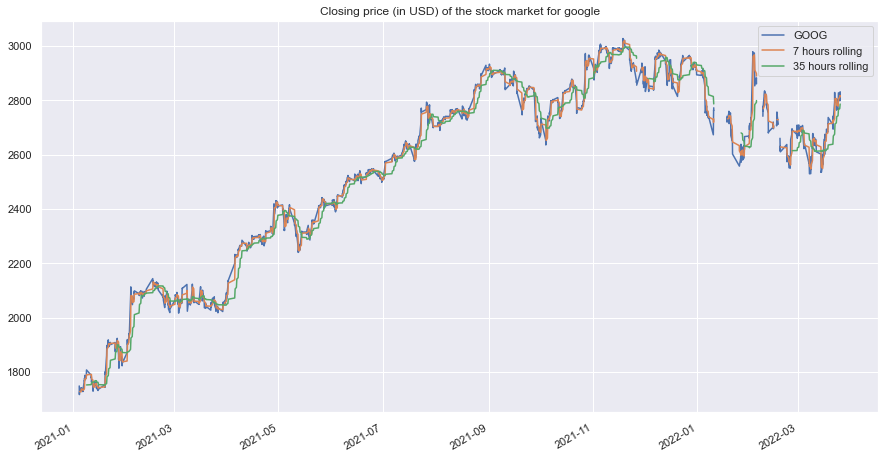

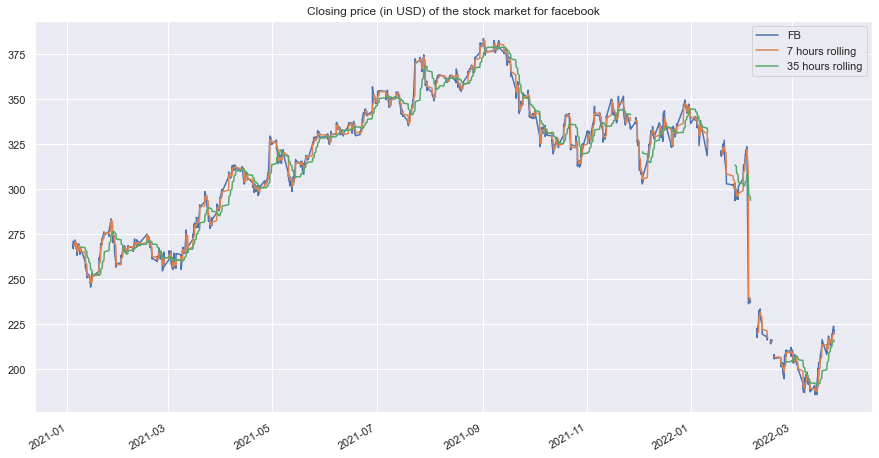

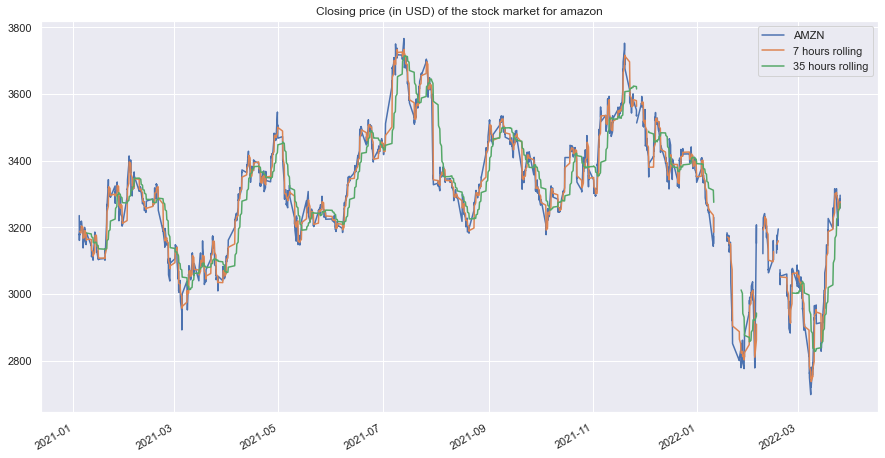

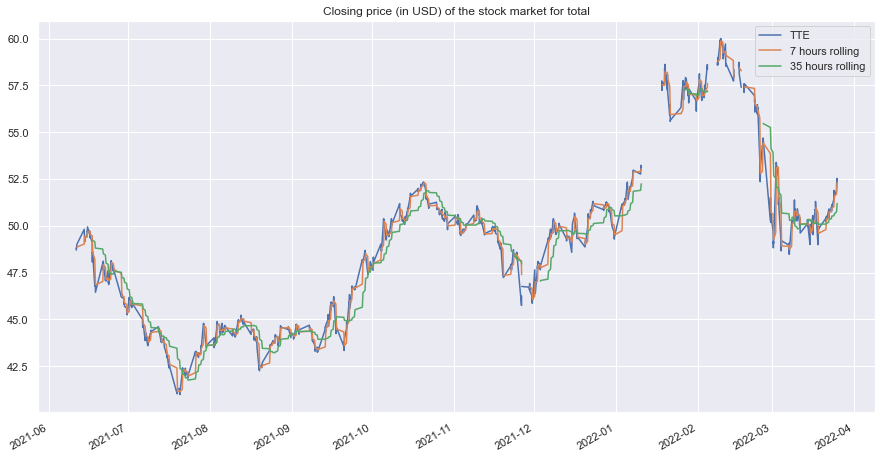

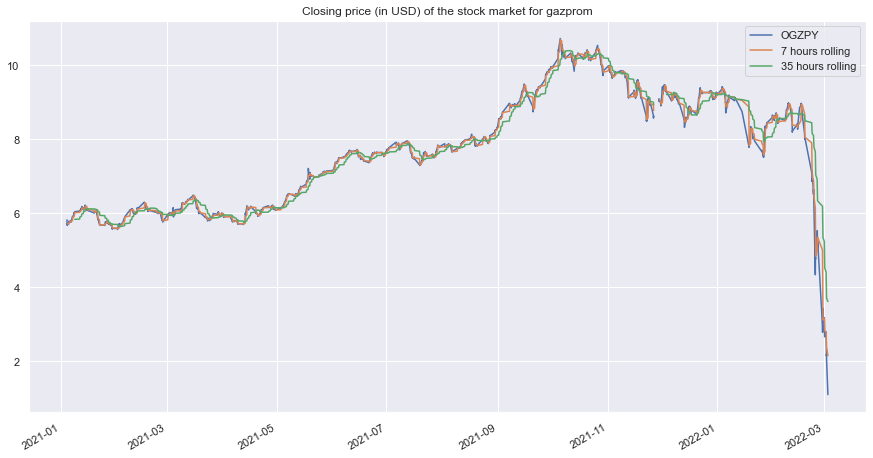

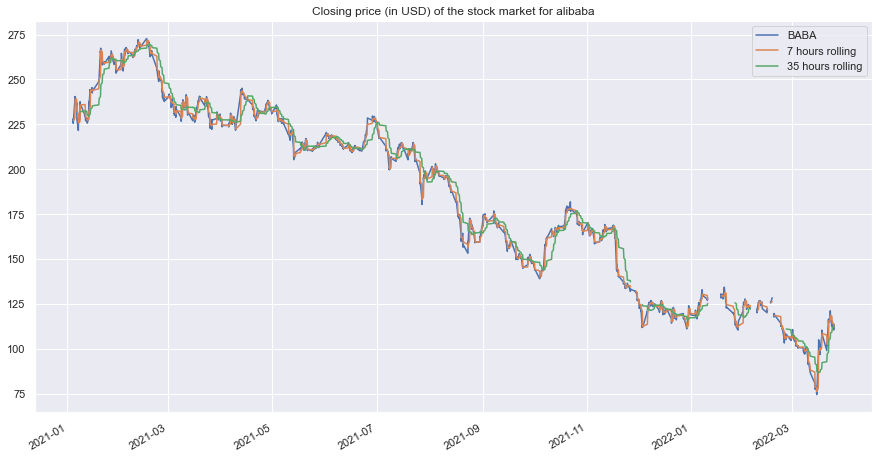

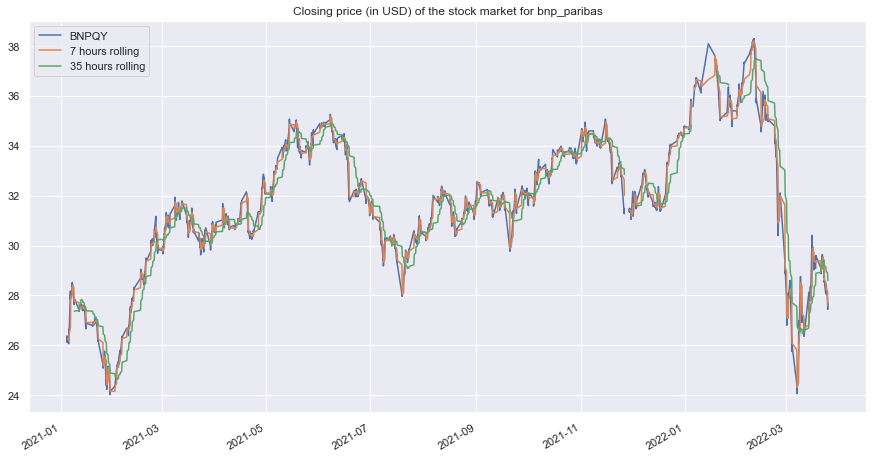

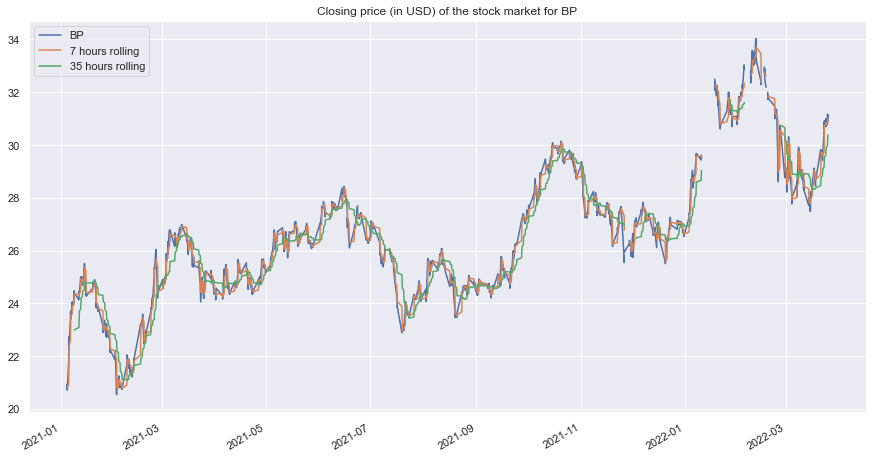

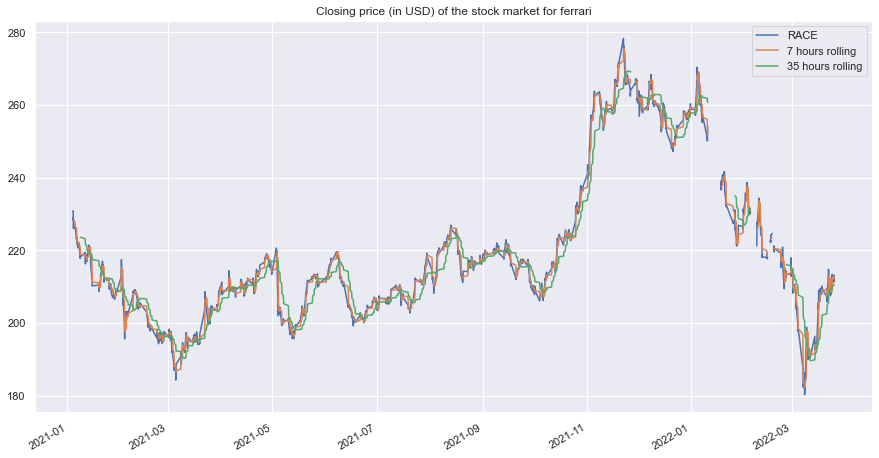

In [119]:
for company in All_the_companies:
    plot_closing(data,
                 company,
                 tick[company],
                 short_window=short_window,
                 long_window=long_window,
                 unite=unite)

# Stock market prediction using batch regression

In [120]:
No_Company = 0              # value from 0 to 8

The_selected_company = All_the_companies[No_Company]
print("The selected company is {}".format(The_selected_company))

The selected company is google


In [121]:
# Initialize a Dictionary to save the results
Batch_ML_result = {}
Batch_ML_result["CPU_time"] = []
Batch_ML_result["MAE"] = []
Batch_ML_result["date"] = []
Batch_ML_result["Regression"] = []
Batch_ML_result["Company"] = []

In [122]:
if the_data_type == Information.RECENT:
    date_deb_test = datetime(2022, 3, 1)
    date_fin_train = date_deb_test - timedelta(hours=1)
elif the_data_type == Information.HISTORICAL:
    date_deb_test = datetime(2022, 1, 1)
    date_fin_train = date_deb_test - timedelta(days=1)
else:
    print("ERROR : 'the_data_type' is not correctly set")
    print("============================================")

## Split the data between the train and test datasets.

In [123]:
Close_price_for_the_selected_company = data[(tick[The_selected_company], "Close")]

# Delete the NaN values
data_clean = Close_price_for_the_selected_company.dropna()

data_train = data_clean[:date_fin_train]
data_test = data_clean[date_deb_test:]

data_test

2022-03-01 09:30:00-05:00    2709.040039
2022-03-01 10:30:00-05:00    2703.479980
2022-03-01 11:30:00-05:00    2689.870117
2022-03-01 12:30:00-05:00    2668.969971
2022-03-01 13:30:00-05:00    2680.090088
                                ...     
2022-03-25 11:30:00-04:00    2810.010498
2022-03-25 12:30:00-04:00    2812.514893
2022-03-25 13:30:00-04:00    2827.635010
2022-03-25 14:30:00-04:00    2812.379883
2022-03-25 15:30:00-04:00    2831.429932
Name: (GOOG, Close), Length: 133, dtype: float64

## ARMA Model

In [124]:
def Modele_ARIMA(Serie, p, q, d = 0):
    """
    Input parameters : Time series and parameters p, d, q (default value of d is 0 : ARMA model)
    
    Return : Model trained on the time series data
    """
    
    # Model building from the Series data
    Modele = ARIMA(Serie, order=(p, d, q)).fit()
    
    # Model quality
    print(Modele.summary())
    
    # Extraction of residue
    Residu = Modele.resid
    
    # Statistical tests on the residue
    
    # 1 - White noise
    df_result = acorr_ljungbox(Residu, boxpierce=True)
    p_value_Box_Pierce = df_result["bp_pvalue"].iloc[0]
    
    # 2 - Normal distribution
    statistique, p_value_Shapiro = stats.shapiro(Residu)
    
    # 3 - Stationarity
    adf, p_value_ADF, usedlag, nobs, critical_values, icbest = adfuller(Residu)
    kpss_stat, p_value_KPSS, lags, crit = kpss(Residu)

    
    print("")
    print("\nBox-Pierce test: pvalue = {}".format(p_value_Box_Pierce))
    if (p_value_Box_Pierce > 0.05):
        print("The residual is a white noise because the hypothesis H0 is satisfied")
    else:
        print("The residual is not a white noise because the hypothesis H0 is not satisfied")
    
    print("\nShapiro-Wilk test: pvalue = {}".format(p_value_Shapiro))
    if (p_value_Shapiro > 0.05):
        print("The residual follows a Normal distribution because the hypothesis H0 is verified")
    else:
        print("The residual does not follow a Normal distribution because the hypothesis H0 is not verified")

    print("\nAugmented Dickey Fuller Test: pvalue = {}".format(p_value_ADF))
    if (p_value_ADF > 0.05):
        print("The residual is not a stationary process because the hypothesis H0 is verified")
    else:
        print("The residual is a stationary process because the hypothesis H0 is not verified")
        
    print("\nKwiatkowski-Phillips-Schmidt-Shin test: pvalue = {}".format(p_value_KPSS))
    if (p_value_KPSS > 0.05):
        print("The residual is a stationary process because the hypothesis H0 is verified")
    else:
        print("The residual is not a stationary process because the hypothesis H0 is not verified")
    
    return Modele

In [125]:
def Modele_Predict(Modele, Test):
    """
    Input data: Trained ARIMA model and time series Test
    
    Return: the prediction score and the dataframe with the values predicted by the model 
    """
    Valeurs_predites = Modele.get_forecast(len(Test))
    df_Prediction = Valeurs_predites.summary_frame()
    df_Prediction["date"] = Test.index.tolist()
    df_Prediction.set_index("date", inplace=True)
    df_Prediction.drop(["mean_se"], axis="columns", inplace=True)
    df_Prediction.rename(columns={"mean": "Prediction", 
                                  "mean_ci_lower": "Borne_Inf_95",
                                  "mean_ci_upper": "Borne_Sup_95"}, inplace=True)
    
    # Scores of the prediction
    MAE = mean_absolute_error(Test, df_Prediction["Prediction"])
    
    return (MAE, df_Prediction)

In [126]:
def plot_predict_ARMA(The_selected_company, data_clean, The_model, df_Prediction, p=1, q=1):
    """
    Plot the prediction values and the true values of the closing stock price
    """
    deb = data_clean.head(1).index.strftime("%d/%m/%Y %H:%M:%S").tolist()[0]
    fin = data_clean.tail(1).index.strftime("%d/%m/%Y %H:%M:%S").tolist()[0]
    # Link between the train values and the predict values to avoid a gap in the curve
    df_Lien_Train_Test = pd.concat([The_model.fittedvalues.tail(1),
                                    df_Prediction["Prediction"].head(1)])

    (fig, ax) = plt.subplots(figsize=(15, 8))
    ax.plot(data_clean, color="red", label="True values")
    ax.plot(The_model.fittedvalues, color="blue", label="Train model")
    ax.plot(df_Lien_Train_Test, color="blue")
    ax.plot(df_Prediction["Prediction"], color="green", label="Prediction")
    ax.fill_between(df_Prediction.index, 
                    df_Prediction['Borne_Inf_95'], 
                    df_Prediction['Borne_Sup_95'], color='yellow', alpha=0.6, label="95% confidence interval")
    Titre = "ARMA({},{}) model of the closing price for the {} stock between {} and {}" \
        .format(p, q, The_selected_company, deb, fin)
    plt.title(Titre)
    plt.legend(loc='upper left')
    plt.show()

### Determination of the model parameters from the AutoCorrelation Function (ACF) and the Partial AutoCorrelation Function (PACF)

In [127]:
# The data describe the closing price throughout the year.
if the_data_type == Information.RECENT:
    # Without any a priori information, we plot the autocorrelation 
    # with lags = 7 hours (1 day), 35 hours (1 week) and 140 hours (1 month)
    lags = [140, 35, 7]
elif the_data_type == Information.HISTORICAL:
    # Without any a priori information, we plot the autocorrelation 
    # with lags = 5 days (1 week), 20 days (1 month) and 240 days (1 year)
    lags = [240, 20, 5]
else:
    print("ERROR : 'the_data_type' is not correctly set")
    print("============================================")

In [128]:
def plot_ACF_and_PACF(data_train, lags):
    for lag in lags:
        plt.figure(figsize=(12, 8) )
        plt.subplot(211)
        courbe_1 = plot_acf(data_train, lags=lag, ax=plt.gca())
        plt.subplot(212)
        courbe_2 = plot_pacf(data_train, lags=lag, ax=plt.gca())
        plt.show()

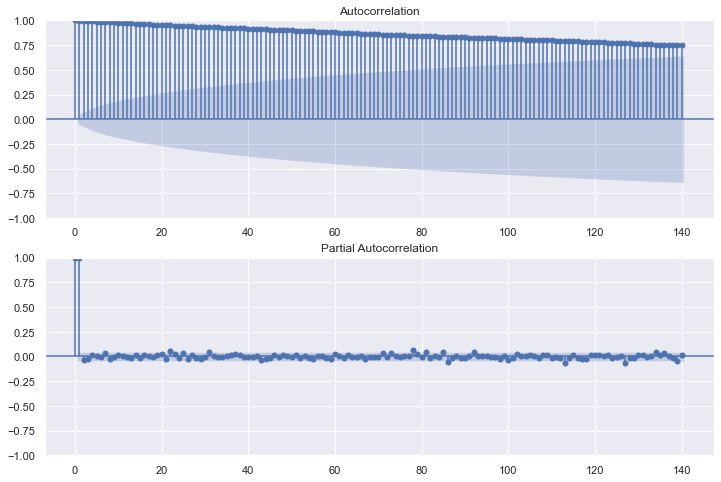

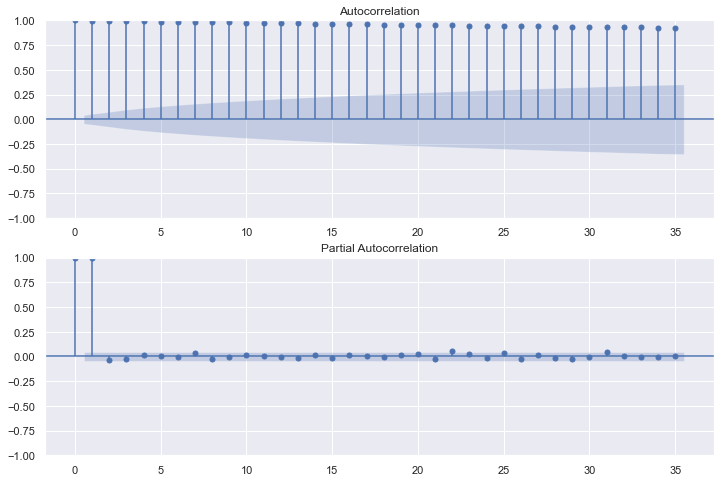

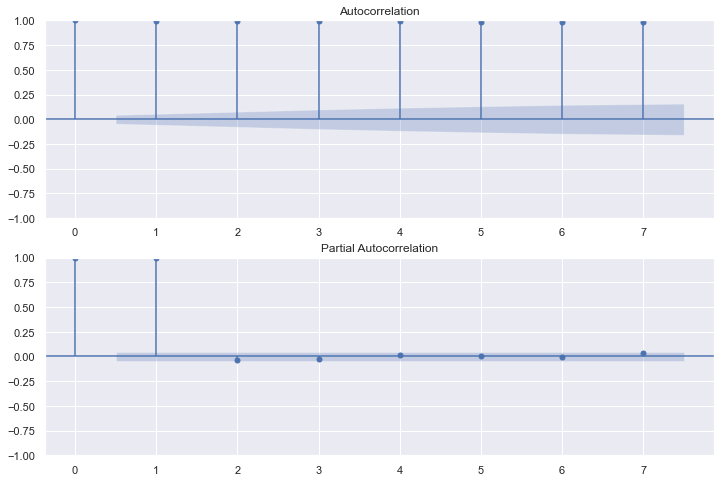

In [129]:
plot_ACF_and_PACF(data_train, lags)

<div class="alert alert-block alert-info">
<p><b>COMMENT :</b></p>

<p>The p and q values of an ARMA model can be derived using two tools:</p>

<p>- The autocorrelogram for the parameter q of the MA model (Moving Average Model).</p>

<p>- The partial autocorrelogram for the parameter p of the AR model (Auto-Regressive Model).</p>

<p>For each curve, we consider the smallest value that is significantly outside the confidence interval. We find <b>p = 1 and q = 1.</b></p>

<p><b>CONCLUSION :</b> The time series 'Stock market' can be modeled by an ARMA(1,1) process</p>
</div>

## Batch Machine Learning

In [130]:
print("\n---------------------- Close price train for {} ----------------------".format(The_selected_company))
temps = perf_counter()

Modele_11 = Modele_ARIMA(data_train, 1, 1)

temps_train_Modele_11 = perf_counter() - temps
Batch_ML_result["CPU_time"].append(temps_train_Modele_11)
print("")
print("+--------------------------+")
print("| CPU time = {:.3f} seconds |".format(temps_train_Modele_11))
print("+--------------------------+")


---------------------- Close price train for google ----------------------
                               SARIMAX Results                                
Dep. Variable:      ('GOOG', 'Close')   No. Observations:                 1967
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -8154.342
Date:                Sun, 27 Mar 2022   AIC                          16316.684
Time:                        14:59:24   BIC                          16339.022
Sample:                             0   HQIC                         16324.893
                               - 1967                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2532.6747    383.397      6.606      0.000    1781.231    3284.119
ar.L1          0.9994      0.001   1223.038      0.000 

In [131]:
MAE, df_Prediction_11 = Modele_Predict(Modele_11, data_test)
print("\nMean Absolute Error of the prediction = {:.2f} USD".format(MAE))
Batch_ML_result["MAE"].append(MAE)
df_Prediction_11


Mean Absolute Error of the prediction = 69.50 USD


"(GOOG, Close)",Prediction,Borne_Inf_95,Borne_Sup_95
date,,,
2022-03-01 09:30:00-05:00,2698.980583,2669.081705,2728.879461
2022-03-01 10:30:00-05:00,2698.883649,2655.734774,2742.032524
2022-03-01 11:30:00-05:00,2698.786771,2645.602376,2751.971167
2022-03-01 12:30:00-05:00,2698.689950,2637.092809,2760.287091
2022-03-01 13:30:00-05:00,2698.593186,2629.609779,2767.576592
...,...,...,...
2022-03-25 11:30:00-04:00,2687.021209,2346.363493,3027.678926
2022-03-25 12:30:00-04:00,2686.931246,2345.052082,3028.810410
2022-03-25 13:30:00-04:00,2686.841335,2343.746487,3029.936183


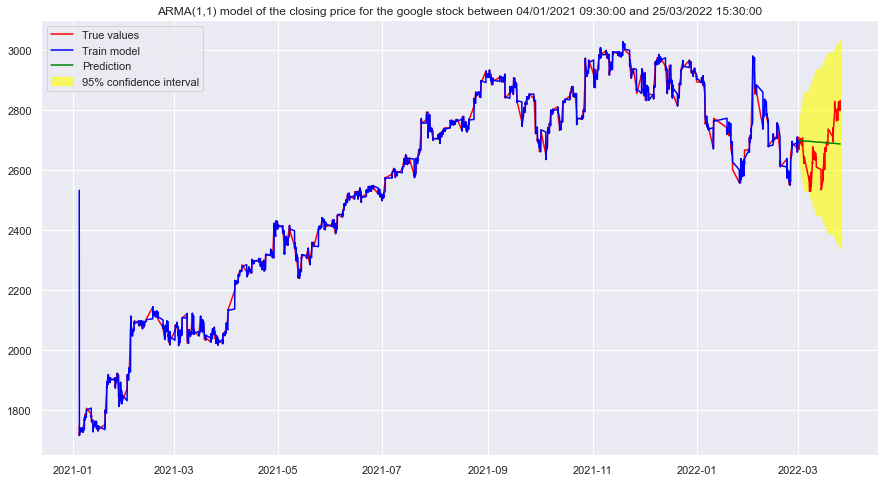

In [132]:
plot_predict_ARMA(The_selected_company, data_clean, Modele_11, df_Prediction_11)

## The performance indicators of the ARMA model are put into a dataframe and stored in csv format. 

__They will be used in the comparison between Batch Machine Learning and On-Line Machine Learning__

In [133]:
print("---------- {} ----------".format(The_selected_company))
Batch_ML_result["date"].append(int(time.time()) * 1000)
Batch_ML_result["Regression"].append("Batch")
Batch_ML_result["Company"].append(The_selected_company)

df_Batch_ML_result = pd.DataFrame(Batch_ML_result)
df_Batch_ML_result

---------- google ----------


,CPU_time,MAE,date,Regression,Company
0,2.1933,69.502131,1648385965000,Batch,google


In [134]:
df_Batch_ML_result.to_csv("ARMA_performance.csv", sep=";", decimal=",")

# Processing of stock market data in Kafka

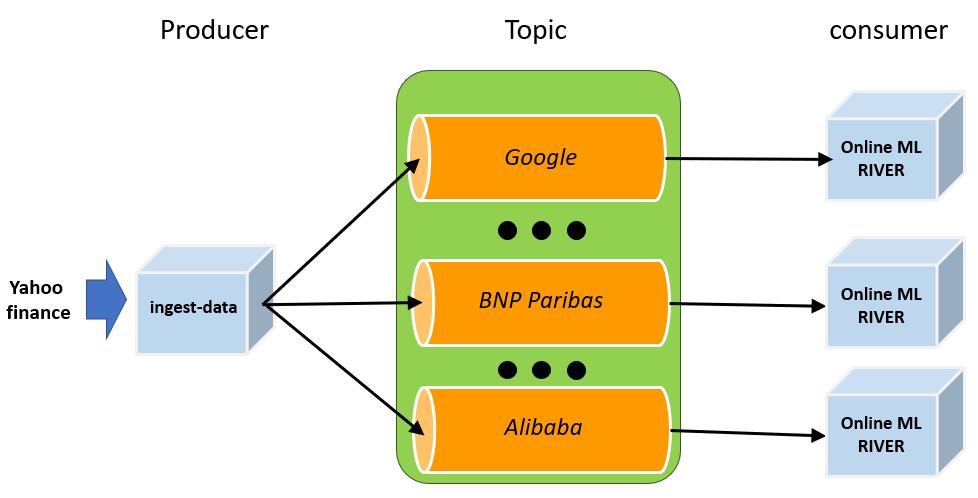

__We create a Kafka topic for each company and stream the stock data retrieved with yfinance into these topics.__

__In another notebook, we will retrieve this stock market data to apply a Machine Learning model with RIVER.__

__In the last notebook, we plot the prediction results from the data stored in the Kafka predicts topics__

## Notebook settings

In [135]:
trace_ingest_data = True
Nb_to_print = 500
pp = pprint.PrettyPrinter()

## Creation of topics if needed

In [136]:
admin_client = KafkaAdminClient(bootstrap_servers="localhost:9092", client_id="Project_DataStream")

topic_name = {}
topic_predict_name = {}

for company in All_the_companies:
    topic_name[company] = company
    topic_predict_name[company] = "predict__{}".format(company)

    # The stock data
    if topic_name[company] not in admin_client.list_topics():
        topic_list = []
        topic_list.append(NewTopic(name=topic_name[company], num_partitions=1, replication_factor=1))
        admin_client.create_topics(new_topics=topic_list, validate_only=False)

    # The predict results
    if topic_predict_name[company] not in admin_client.list_topics():
        topic_list = []
        topic_list.append(NewTopic(name=topic_predict_name[company], num_partitions=1, replication_factor=1))
        admin_client.create_topics(new_topics=topic_list, validate_only=False)

## Kafka Producer : ingest_data

In [137]:
if trace_ingest_data:
    print("-----  INGEST DATA FROM YAHOO FINANCE  ----")

producer = KafkaProducer(bootstrap_servers="localhost:9092")

Nb_items = {}
for company in All_the_companies:
    Nb_items[company] = 0

try:
    for date, col in data.iterrows():        
        ligne = {}
        for company in All_the_companies:
            ligne[tick[company]] = {}
            ligne[tick[company]]["date"] = int(datetime.timestamp(date))*1000

        for indice in col.index:
            ligne[indice[0]][indice[1]] = col[indice]

        for company in All_the_companies:
            if not math.isnan(ligne[tick[company]]["Open"]):
                Nb_items[company] += 1
                producer.send(topic_name[company], json.dumps(ligne[tick[company]]).encode())
            
                if Nb_items[company] == 1:
                    if trace_ingest_data:
                        print("---------- {} ----------".format(company))
                        pp.pprint(ligne[tick[company]])
                        print("")

                if Nb_items[company] % Nb_to_print == 0:
                    if trace_ingest_data:
                        print("{} - {} records sent to the Kafka topic {}" \
                              .format(time.strftime("%d/%m/%Y %H:%M:%S"),
                                      Nb_items[company],
                                      company))

except KeyboardInterrupt:
    if trace_ingest_data:
        print ("----------  END OF INGEST DATA  ----------")
except Exception as e:
    print("An arror has occurred")
    print(e)

-----  INGEST DATA FROM YAHOO FINANCE  ----
---------- google ----------
{'Adj Close': 1748.239990234375,
 'Close': 1748.239990234375,
 'High': 1760.6400146484375,
 'Low': 1740.949951171875,
 'Open': 1758.4200439453125,
 'Volume': 241052.0,
 'date': 1609770600000}

---------- facebook ----------
{'Adj Close': 271.1700134277344,
 'Close': 271.1700134277344,
 'High': 273.8999938964844,
 'Low': 269.9800109863281,
 'Open': 273.75,
 'Volume': 2708653.0,
 'date': 1609770600000}

---------- amazon ----------
{'Adj Close': 3235.080078125,
 'Close': 3235.080078125,
 'High': 3271.175048828125,
 'Low': 3217.0,
 'Open': 3271.03125,
 'Volume': 817344.0,
 'date': 1609770600000}

---------- gazprom ----------
{'Adj Close': 5.820000171661377,
 'Close': 5.820000171661377,
 'High': 5.829999923706055,
 'Low': 5.800000190734863,
 'Open': 5.809999942779541,
 'Volume': 0.0,
 'date': 1609770600000}

---------- alibaba ----------
{'Adj Close': 227.75,
 'Close': 227.75,
 'High': 230.3800048828125,
 'Low': 225.